# Chapter 3: Defining computation

Code related to [Chapter 3: Defining computation](https://introtcs.org/public/lec_03_computation.html) in __Introduction to Theoretical Computer Science__ by Boaz Barak. [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/boazbk/tcscode/blob/master/Chap_03_computation.ipynb)


In [ ]:
!wget https://raw.githubusercontent.com/boazbk/tcscode/master/Utilities.ipynb
# get utility code from repository

In [3]:
!pip install schemdraw

In [15]:
import schemdraw as schem
import schemdraw.elements as elm
from schemdraw import logic
import schemdraw

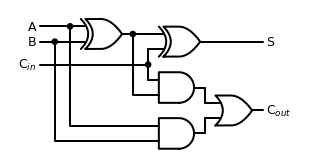

In [16]:
with schemdraw.Drawing() as d:
    d.config(unit=0.5)
    d += (X1 := logic.Xor())
    d += (A := logic.Line().left(d.unit*2).at(X1.in1).idot().label('A', 'left'))
    d += (B := logic.Line().left().at(X1.in2).dot())
    d += logic.Line().left().label('B', 'left')

    d += logic.Line().right().at(X1.out).idot()
    d += (X2 := logic.Xor().anchor('in1'))
    d += (C := logic.Line().down(d.unit*2).at(X2.in2))
    d.push()
    d += logic.Dot().at(C.center)
    d += logic.Line().tox(A.end).label('C$_{in}$', 'left')
    d.pop()

    d += (A1 := logic.And().right().anchor('in1'))
    d += logic.Wire('-|').at(A1.in2).to(X1.out)
    d.move_from(A1.in2, dy=-d.unit*2)
    d += (A2 := logic.And().right().anchor('in1'))
    d += logic.Wire('-|').at(A2.in1).to(A.start)
    d += logic.Wire('-|').at(A2.in2).to(B.end)
    d.move_from(A1.out, dy=-(A1.out.y-A2.out.y)/2)
    d += (O1 := logic.Or().right().label('C$_{out}$', 'right'))
    d += logic.Line().at(A1.out).toy(O1.in1)
    d += logic.Line().at(A2.out).toy(O1.in2)
    d += logic.Line().at(X2.out).tox(O1.out).label('S', 'right')

In [10]:
def f():
    with schem.Drawing() as d:
        d += elm.Resistor()
        d += elm.Capacitor()
        d += elm.Diode()

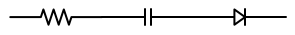

In [11]:
f()

In [6]:
# utility code 
%run "Utilities.ipynb"
from IPython.display import clear_output
clear_output()

NameError: name 'Circuit' is not defined

NameError: name 'Circuit' is not defined

##  Circuits with AND, OR and NOT

In [5]:
def AND(a,b): return a*b

def OR(a,b): return 1 if a+b else 0

def NOT(a): return 1-a

In [6]:
def EVAL(code,X):
    """Evaluate code on input X."""
    n,m = numinout(code) # helper function - get number of inputs and outputs
    
    vtable = { f"X[{i}]":int(X[i]) for i in range(n)}
    
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        # helper function - split "foo = OP(,blah)" to list ["foo","OP","bar","blah"]
        # 2 is num of arguments to expect: blah is empty if it's missing
        if op=="NOT": vtable[foo] = NOT(vtable[bar])
        if op=="AND": vtable[foo] = AND(vtable[bar],vtable[blah])
        if op=="OR": vtable[foo] =  OR(vtable[bar],vtable[blah])
    
    return [vtable[f"Y[{j}]"] for j in range(m)]            

### Circuit for majority on 3 bits

In [7]:
majcode = r"""firstpair  = AND(X[0],X[1])
secondpair = AND(X[1],X[2])
thirdpair  = AND(X[0],X[2])
temp       = OR(secondpair,thirdpair)
Y[0] =  OR(firstpair,temp)
"""

In [8]:
C = prog2circuit(majcode)
schemdraw(C,filename="majaoncircuit.png")

In [9]:
code = r"""
t1      = AND(X[0],X[1])
notx0   = NOT(X[0])
t2      = AND(notx0,X[2])
Y[0]    = OR(t1,t2)
"""[1:]

In [10]:
EVAL(code,"010")

[0]

In [11]:
prog2circuit(code)

In [13]:
C = prog2circuit(code)
schemdraw(C)

### Circuit for XOR for 3 bits

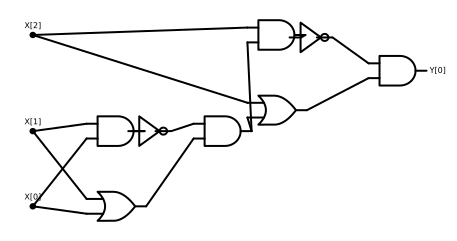

In [20]:
def XOR3(a,b,c):
    w1 = AND(a,b)
    w2 = NOT(w1)
    w3 = OR(a,b)
    w4 = AND(w2,w3)
    w5 = AND(w4,c)
    w6 = NOT(w5)
    w7 = OR(w4,c)
    return AND(w6,w7)

drawcirc(XOR3)

## Transform AND/OR/NOT circuits to NAND circuits

In [21]:
def AON2NAND(code):
    """Translate an AON-CIRC program to an equivalent NAND-CIRC program"""
    output = ""
    counter = 0
    for line in code.split("\n"):
        if not line: continue
        foo,op,bar,blah = parseline(line,2) 
        if op=="NOT":
            output += f"{foo} = NAND({bar},{bar})\n"
        if op=="AND": 
            output += f"temp_{counter} = NAND({bar},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter})\n"
            counter +=1
        if op=="OR":
            output += f"temp_{counter} = NAND({bar},{bar})\n"
            output += f"temp_{counter+1} = NAND({blah},{blah})\n"
            output += f"{foo} = NAND(temp_{counter},temp_{counter+1})\n"
            counter +=2
    return output

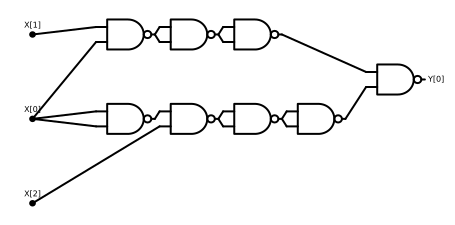

In [22]:
C = prog2circuit(AON2NAND(code))
schemdraw(C)

In [23]:
def BIG1(a,b):
    t = NOT(b)
    return OR(a,t)

def BIG2(X):
    """Input is X[0]...X[3] which we consider as two three-bit numbers A and B. We return 1 iff A>B"""
    y1 = BIG1(X[0],X[2])
    n1 = BIG1(X[2],X[0])
    y2 = BIG1(X[1],X[3])
    t  = AND(y2,n1)
    return OR(y1,t)

In [24]:
code = circuit2prog(circuit(BIG2,4))
print(code)

gate_0 = NOT(X[2])
gate_1 = OR(X[0],gate_0)
gate_2 = NOT(X[0])
gate_3 = OR(X[2],gate_2)
gate_4 = NOT(X[3])
gate_5 = OR(X[1],gate_4)
gate_6 = AND(gate_5,gate_3)
Y[0] = OR(gate_1,gate_6)



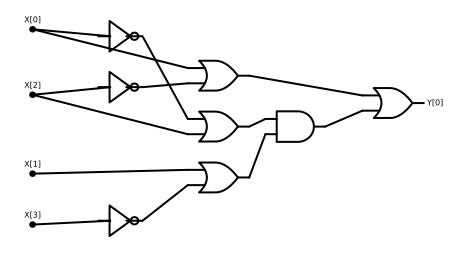

In [25]:
C = prog2circuit(code)
schemdraw(C)

In [26]:
BIG2([1,0,0,1])

1

In [27]:
BIG1(1,0)

1

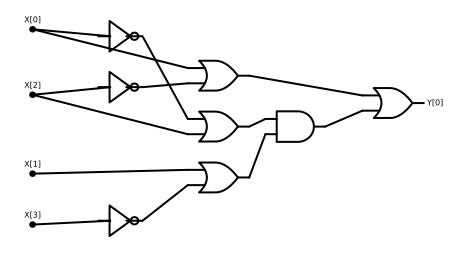

In [28]:
C = prog2circuit(code)
C

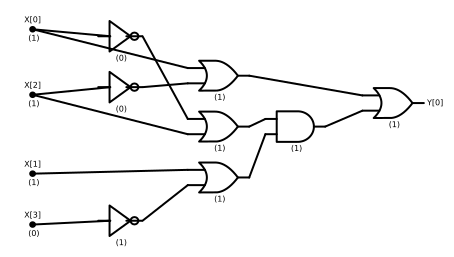

In [29]:
C.render_eval(1,1,1,0)

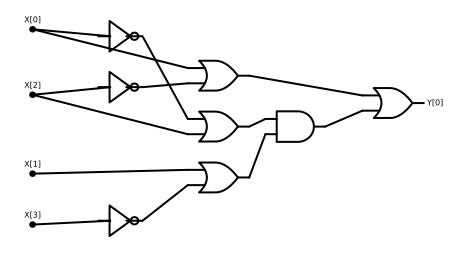

In [30]:
schemdraw(C)

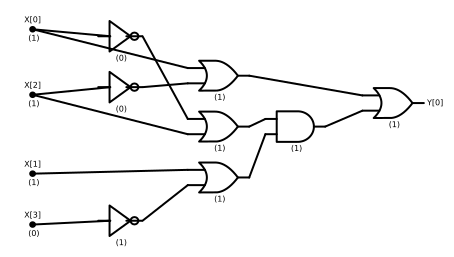

In [31]:
schemdraw(C,[1,1,1,0])

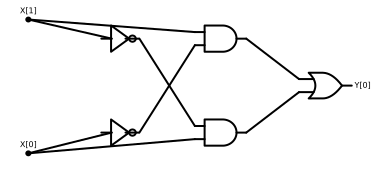

In [32]:
xorcode = r'''notx0 = NOT(X[0])
notx1 = NOT(X[1])
a = AND(X[1],notx0)
b = AND(X[0],notx1)
Y[0] = OR(a,b)
'''
prog2circuit(xorcode)

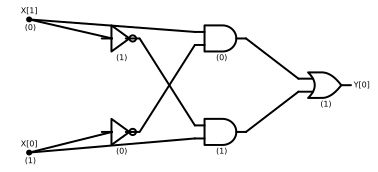

In [35]:
schemdraw(_,[1,0])

Circuit for ALLEQ function

In [38]:
def ALLEQ(a,b,c,d):
    t = AND(AND(AND(a,b),c),d)
    u = AND(AND(AND(NOT(a),NOT(b)),NOT(c)),NOT(d))
    return OR(t,u)

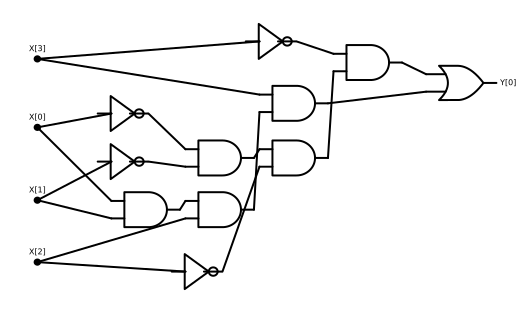

In [39]:
drawcirc(ALLEQ)

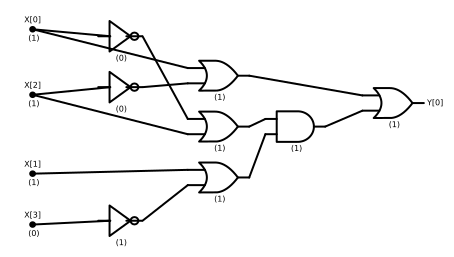

In [40]:
CMPcode = r'''temp_1 = NOT(X[2])
temp_2 = OR(X[0],temp_1)
temp_3 = NOT(X[0])
temp_4 = OR(X[2],temp_3)
temp_5 = NOT(X[3])
temp_6 = OR(X[1],temp_5)
temp_7 = AND(temp_6,temp_4)
Y[0] = OR(temp_2,temp_7)
'''
schemdraw(prog2circuit(CMPcode),[1,1,1,0])

In [41]:
print(function2code(XOR3))


temp_1 = AND(X[0],X[1])
temp_2 = NOT(temp_1)
temp_3 = OR(X[0],X[1])
temp_4 = AND(temp_2,temp_3)
temp_5 = AND(temp_4,X[2])
temp_6 = NOT(temp_5)
temp_7 = OR(temp_4,X[2])
Y[0] = AND(temp_6,temp_7)


In [42]:
code = r'''
temp_1 = NOT(X[2])
temp_2 = AND(X[0],temp_1)
temp_3 = OR(X[0],temp_1)
temp_4 = NOT(X[3])
temp_5 = AND(X[1],temp_4)
temp_6 = AND(temp_5,temp_3)
Y[0] = OR(temp_2,temp_6)
'''
C = circuit(code)
for a in [0,1]:
    for b in [0,1]:
        for c in [0,1]:
            for d in [0,1]:
                print(((a>c) or ((a==c) and (b>d)))==C(a,b,c,d))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


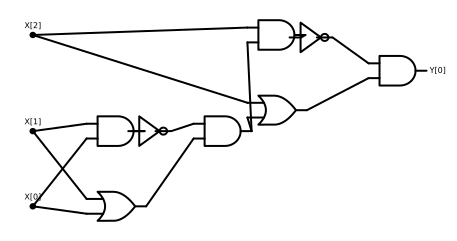

In [43]:
drawcirc(XOR3)

# NAND circuits

In [44]:
code = r'''u = NAND(X[0],X[1])
v = NAND(X[0],u)
w = NAND(X[1],u) 
Y[0] = NAND(v,w)
'''


temp_1 = NAND(X[0],X[1])
temp_2 = NAND(X[0],temp_1)
temp_3 = NAND(X[1],temp_1)
temp_4 = NAND(temp_2,temp_3)
temp_5 = NAND(temp_4,X[2])
temp_6 = NAND(temp_4,temp_5)
temp_7 = NAND(X[2],temp_5)
Y[0] = NAND(temp_6,temp_7)


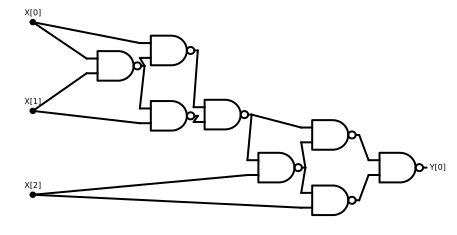

In [45]:
def XORN(a,b):
    u = NAND(a,b)
    v = NAND(a,u)
    w = NAND(b,u)
    return NAND(v,w)

def XOR3(a,b,c):
    return XORN(XORN(a,b),c)

print(function2code(XOR3))
drawcirc(XOR3)

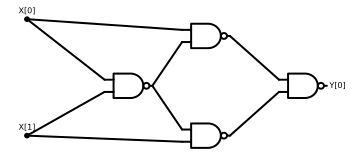

In [46]:
drawcirc(XORN)

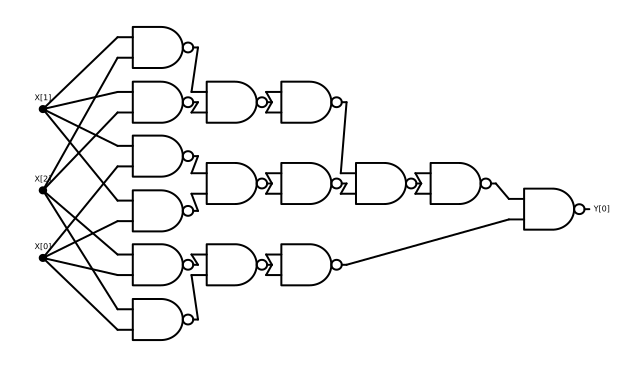

In [48]:
def MAJ3(a,b,c):
    return OR(OR(AND(a,b),AND(b,c)),AND(a,c))

drawcirc(MAJ3,NANDONLY=True)

# Increment

In [49]:
def one(a):
    return NAND(a,NAND(a,a))

def INC(X):
    n = len(X)
    Y=[0]*(n+1)
    c = one(X[0])
    for i in range(n):
        Y[i] = XORN(c,X[i])
        c = AND(X[i],c)
    Y[n] = c
    return Y
    

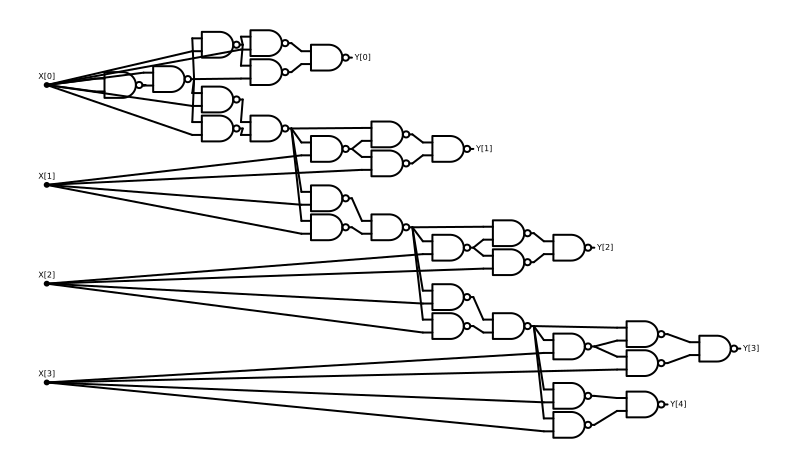

In [50]:
drawcirc(INC,4,NANDONLY=True)


# Neural net activation functions

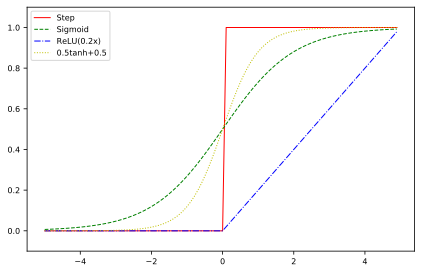

In [51]:
import numpy as np
import matplotlib.pylab as plt


def step(x):
    return np.array(x > 0, dtype=np.int)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, 0.2*x)

def mytanh(x):
    return 0.5*np.tanh(x)+0.5

x = np.arange(-5.0, 5.0, 0.1)
y_step = step(x)
y_sigmoid = sigmoid(x)
y_relu = relu(x)
y_tanh = mytanh(x)

plt.plot(x, y_step, label='Step', color='r', lw=1, linestyle=None)
plt.plot(x, y_sigmoid, label='Sigmoid', color='g', lw=1, ls='--')
plt.plot(x, y_relu, label='ReLU(0.2x)', color='b', lw=1, linestyle='-.')
plt.plot(x, y_tanh, label='0.5tanh+0.5',color='y',lw=1,linestyle=':')
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

### Misc code (can ignore for now)

In [52]:
code = r'''temp_0 = NAND(X[0],X[0])
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
'''

In [53]:
code = r'''temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker[i] = NAND(X_nonblank[i],X_noblank[i])
Atend[i] = NAND(X_nonblank[i],X_nonblank[i])
temp_2 = NAND(X[i],Y[0])
temp_3 = NAND(X[i],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
'''

In [55]:
res = ""
for i in [0,1,2,3]:
    res += code.replace('[i]',f'[{i}]')
print(res)

temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker[0] = NAND(X_nonblank[0],X_noblank[0])
Atend[0] = NAND(X_nonblank[0],X_nonblank[0])
temp_2 = NAND(X[0],Y[0])
temp_3 = NAND(X[0],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker[1] = NAND(X_nonblank[1],X_noblank[1])
Atend[1] = NAND(X_nonblank[1],X_nonblank[1])
temp_2 = NAND(X[1],Y[0])
temp_3 = NAND(X[1],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker[2] = NAND(X_nonblank[2],X_noblank[2])
Atend[2] = NAND(X_nonblank[2],X_nonblank[2])
temp_2 = NAND(X[2],Y[0])
temp_3 = NAND(X[2],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_0 = NAND(X[0],X[0])
Y_nonblank[0] = NAND(X[0],temp_0)
Atstart[0] = NAND(X[0],temp_0) 
Marker[3] = NAND(X_nonblank[3],X_noblank[3])
Ate

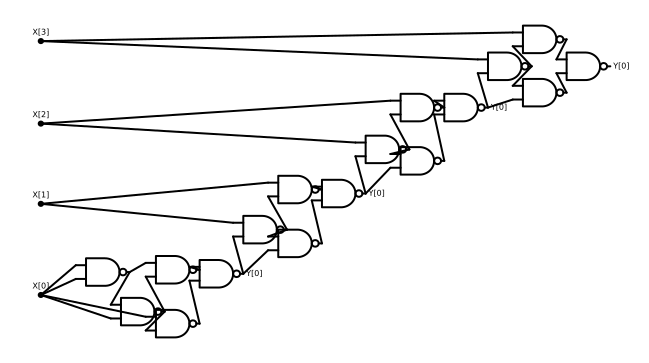

In [56]:
res = r'''temp_0 = NAND(X[0],X[0])
temp_2 = NAND(X[0],temp_0)
temp_3 = NAND(X[0],temp_2)
temp_4 = NAND(temp_0,temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_2 = NAND(X[1],Y[0])
temp_3 = NAND(X[1],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_2 = NAND(X[2],Y[0])
temp_3 = NAND(X[2],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
temp_2 = NAND(X[3],Y[0])
temp_3 = NAND(X[3],temp_2)
temp_4 = NAND(Y[0],temp_2)
Y[0] = NAND(temp_3,temp_4)
'''
C = prog2circuit(res)
schemdraw(C)